
Teste de Estacionariedade da Série Original:
Teste ADF:
Estatística ADF: -1.6415260145103248
p-valor: 0.4614635174745362
Valores Críticos:
   1%: -3.49181775886872
   5%: -2.8884437992971588
   10%: -2.5811201893779985
A série NÃO é estacionária!

Aplicando diferenciação para tornar a série estacionária...

Teste de Estacionariedade da Série Diferenciada:
Teste ADF:
Estatística ADF: -8.394253491113638
p-valor: 2.3219794702479637e-13
Valores Críticos:
   1%: -3.49181775886872
   5%: -2.8884437992971588
   10%: -2.5811201893779985
A série é estacionária !


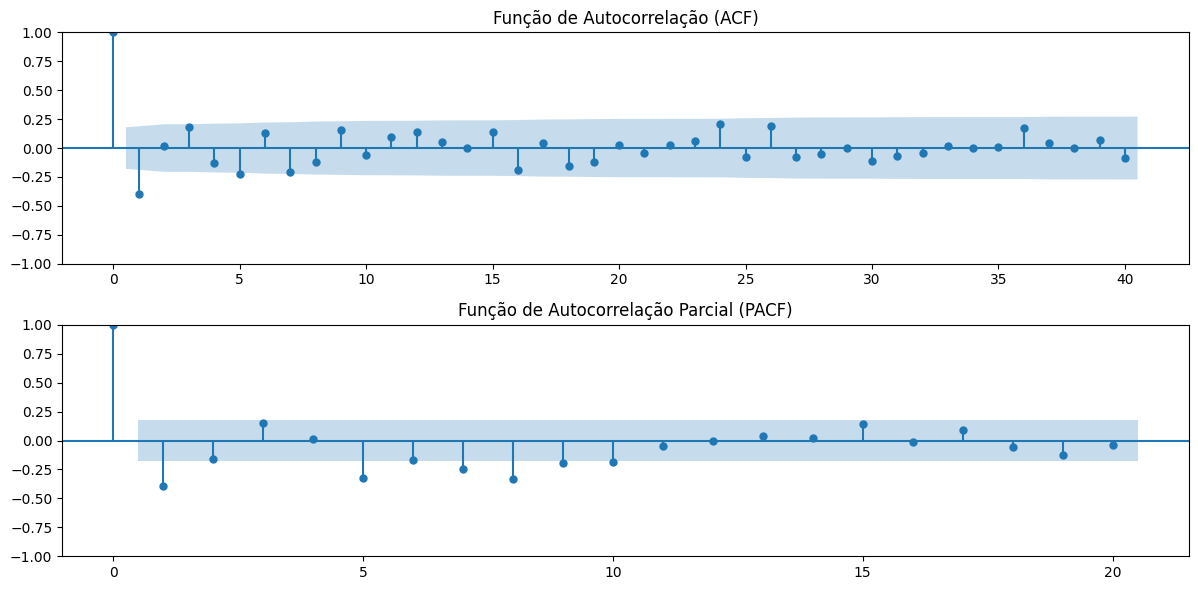

c:\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



MAPE: 0.06%
            Valor Real  Valor Previsto
2024-01-01      189664   205641.767870
2024-02-01      185982   194268.749213
2024-03-01      184109   196427.394060
2024-04-01      199395   190347.993782
2024-05-01      177871   179109.525185
2024-06-01      184680   182307.203159
2024-07-01      161149   179005.002570
2024-08-01      169700   178724.960940
2024-09-01      180721   176610.472813
2024-10-01      173691   185944.256140
2024-11-01      179036   192187.656338
2024-12-01      182626   201549.795132


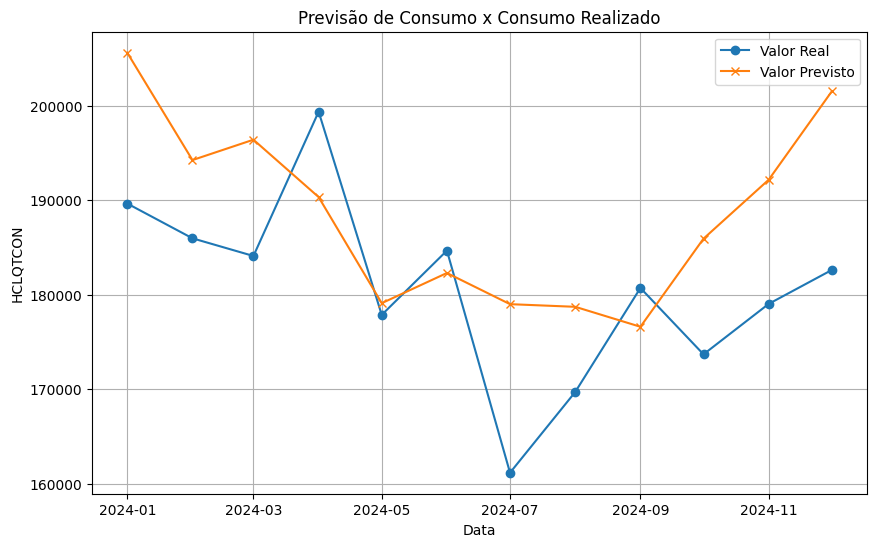

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error as mape
import os

# Função para testar a estacionariedade da série temporal
def testar_estacionariedade(serie):
    resultado = adfuller(serie.dropna())
    print('Teste ADF:')
    print(f'Estatística ADF: {resultado[0]}')
    print(f'p-valor: {resultado[1]}')
    print('Valores Críticos:')
    for chave, valor in resultado[4].items():
        print(f'   {chave}: {valor}')
    if resultado[1] <= 0.05:
        print("A série é estacionária !")
    else:
        print("A série NÃO é estacionária!")

# Função para realizar a previsão e plotar o gráfico
def prever_e_plotar(caminho_arquivo):
    # Carregando os dados do CSV
    df = pd.read_csv(caminho_arquivo, sep=';')

    # Convertendo AM_REFERENCIA para datetime
    df['AM_REFERENCIA'] = pd.to_datetime(df['AM_REFERENCIA'], format='%Y%m')

    # Agregando os dados por AM_REFERENCIA, somando HCLQTCON
    df_aggregated = df.groupby('AM_REFERENCIA')['HCLQTCON'].sum().reset_index()

    # Ordenando por data
    df_aggregated = df_aggregated.sort_values(by='AM_REFERENCIA')

    # Definindo a série temporal
    ts = df_aggregated.set_index('AM_REFERENCIA')['HCLQTCON']

    # Testando a estacionariedade da série temporal
    print("\nTeste de Estacionariedade da Série Original:")
    testar_estacionariedade(ts)

    # Aplicando diferenciação para tornar a série estacionária (se necessário)
    if adfuller(ts.dropna())[1] > 0.05:
        print("\nAplicando diferenciação para tornar a série estacionária...")
        ts_diff = ts.diff().dropna()
        print("\nTeste de Estacionariedade da Série Diferenciada:")
        testar_estacionariedade(ts_diff)
    else:
        ts_diff = ts

    # Plotando ACF e PACF para identificar p, q, P e Q
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plot_acf(ts_diff, lags=min(40, len(ts_diff) - 1), ax=plt.gca())  # Ajuste o número de lags
    plt.title('Função de Autocorrelação (ACF)')

    plt.subplot(2, 1, 2)
    plot_pacf(ts_diff, lags=min(20, len(ts_diff) // 2), ax=plt.gca())  # Ajuste o número de lags
    plt.title('Função de Autocorrelação Parcial (PACF)')
    plt.tight_layout()
    plt.show()

    # Dividindo os dados em treino e teste
    train = ts['2015-01':'2023-12']
    test = ts['2024-01':'2024-12']

    # Ajustando o modelo SARIMA
    # Parâmetros (p,d,q) e (P,D,Q,s) podem ser ajustados conforme necessário
    model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    # Fazendo previsões
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

    # Criando um DataFrame para comparar valores reais e previstos
    comparison_df = pd.DataFrame({
        'Valor Real': test,
        'Valor Previsto': predictions
    })

    # Avaliando o modelo com MAPE
    mape_value = mape(test, predictions)
    print(f'\nMAPE: {mape_value:.2f}%')

    # Exibindo os valores reais e previstos
    print(comparison_df)

    # Plotando o gráfico de previsão x realizado
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test, label='Valor Real', marker='o')
    plt.plot(predictions.index, predictions, label='Valor Previsto', marker='x')
    plt.title('Previsão de Consumo x Consumo Realizado')
    plt.xlabel('Data')
    plt.ylabel('HCLQTCON')
    plt.legend()
    plt.grid(True)
    plt.show()

# Caminho do arquivo CSV
path = 'E:\\Projetos\\ABMS-WP'
caminho_arquivo = os.path.join(path, 'includes\\Tabela_consumo_Itapua_120m.csv')

# Chamando a função
prever_e_plotar(caminho_arquivo)